# Week 8 Jupyter Notebook - K-Nearest Neighbors
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone Two, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For this week, include ideas such as **K-Nearest Neighbors** and **distance metrics**. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In Week 12, you will compile your findings from your Jupyter Notebook homework into your Milestone Two assignment for grading. For full instructions and the rubric for Milestone Two, refer to the following link. 

K-nearest neighbors (with different metrics) (Week 8)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           make_scorer, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

## Dataset 1 Initial Fit

In [2]:
def load_collision_data():
    """Load the collision feature datasets"""
    print("\n STEP 1: Loading collision feature datasets...")
    
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f" Loaded {len(injury_df)} injury collisions")
    print(f" Loaded {len(normal_df)} normal collisions")
    
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f" Combined dataset: {len(combined_df)} total collisions")
    print(f" Injury rate: {combined_df['is_injury'].mean():.1%}")
    
    return combined_df, injury_df, normal_df

combined_df, injury_df, normal_df = load_collision_data()


 STEP 1: Loading collision feature datasets...
 Loaded 28 injury collisions
 Loaded 280 normal collisions
 Combined dataset: 308 total collisions
 Injury rate: 9.1%


In [3]:
def preprocess_small_dataset(df, target_col='is_injury', remove_outliers=False):
    """Conservative preprocessing for small datasets"""
    print("\n STEP 2: Conservative preprocessing for small dataset...")
    
    # Identify feature columns
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing (more conservative for small datasets)
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f"🗑️ Removing {len(high_missing)} features with >50% missing data")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Simple imputation for small datasets
    print(" Handling missing data with median imputation...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Only create most important engineered features
    print(" Creating key engineered features...")
    
    # Collision intensity (most important from previous analysis)
    if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
        X['collision_intensity'] = (1 / (X['min_distance'] + 0.1)) * (X['max_relative_speed'] / X['max_relative_speed'].max())
    
    # Speed ratio
    if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
        X['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
    
    # Conservative outlier removal (only extreme outliers)
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[col].quantile(0.05)  # More conservative percentiles
            Q3 = X[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
            upper_bound = Q3 + 3 * IQR
            
            col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"🗑️ Removed {outlier_count} extreme outliers")
        else:
            print(f"⚠️ Skipping outlier removal (would remove {outlier_count} samples)")
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    return X, y

# Preprocess with conservative settings
X, y = preprocess_small_dataset(combined_df, remove_outliers=False)  # Skip outlier removal


 STEP 2: Conservative preprocessing for small dataset...
 Identified 23 potential features
 Features after missing data filter: 23
 Handling missing data with median imputation...
 Creating key engineered features...
 Final dataset: 308 samples, 25 features
 Class distribution: {0: 280, 1: 28}


In [4]:
def select_features_small_dataset(X, y, k=8):
    """Feature selection optimized for small datasets"""
    print(f"\n STEP 3: Selecting top {k} features for small dataset...")
    
    # Use fewer features for small datasets to avoid overfitting
    k = min(k, X.shape[1], len(y) // 3)  # Rule: max features = samples/3
    
    if X.shape[1] > k:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features:")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} Score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
    
    # Scale features
    print(" Scaling features...")
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_selected),
        columns=selected_features,
        index=X_selected.index
    )
    
    return X_scaled, selected_features, scaler

X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=8)


 STEP 3: Selecting top 8 features for small dataset...
 Selected features:
   min_distance                   Score: 45.60
   distance_at_end                Score: 7.03
   avg_distance                   Score: 6.95
   time_to_closest_approach       Score: 54.27
   max_relative_speed             Score: 87.67
   p2_max_speed                   Score: 7.52
   play_duration                  Score: 48.04
   collision_intensity            Score: 282.39
 Scaling features...


In [8]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_models_small_dataset(X, y, feature_names):
    """Model evaluation optimized for small datasets using cross-validation"""
    print("\n STEP 4: Model evaluation with cross-validation...")
    
    # Simpler models for small datasets
    models = {
        'NearestNeighbors': KNeighborsClassifier(
            n_neighbors=3, weights='uniform', algorithm='auto'
        )
    }
    
    print(f" Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    # Use Leave-One-Out CV for very small datasets
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=min(5, len(y[y==1])), shuffle=True, random_state=42)
        cv_name = "Stratified K-Fold"
    
    print(f" Using {cv_name} cross-validation...")
    
    results = {}
    
    # Custom scoring for small datasets
    def balanced_accuracy_score(y_true, y_pred):
        from sklearn.metrics import balanced_accuracy_score as bas
        return bas(y_true, y_pred)
    
    for name, model in models.items():
        print(f"\n Evaluating {name}...")
        
        try:
            # Cross-validation scores
            cv_scores_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_scores_bal = cross_val_score(model, X, y, cv=cv, 
                                          scoring=make_scorer(balanced_accuracy_score))
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[name] = {
                'model': model,
                'cv_accuracy': cv_scores_acc,
                'cv_balanced_accuracy': cv_scores_bal,
                'mean_accuracy': cv_scores_acc.mean(),
                'mean_balanced_accuracy': cv_scores_bal.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   Accuracy: {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")
            print(f"   Balanced Accuracy: {cv_scores_bal.mean():.3f} ± {cv_scores_bal.std():.3f}")
            
            # Classification report
            report = classification_report(y, y_pred, output_dict=True, zero_division=0)
            if '1' in report:
                print(f"   Injury Detection - Precision: {report['1']['precision']:.3f}, Recall: {report['1']['recall']:.3f}")
            
        except Exception as e:
            print(f"    Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_balanced_accuracy'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n Best model: {best_model_name}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n No models evaluated successfully")
    
    return results, best_model, best_model_name

results, best_model, best_model_name = evaluate_models_small_dataset(X_scaled, y, feature_names)


 STEP 4: Model evaluation with cross-validation...
 Dataset: 308 samples, 8 features
 Class distribution: {0: 280, 1: 28}
 Using Stratified K-Fold cross-validation...

 Evaluating NearestNeighbors...
   Accuracy: 0.964 ± 0.024
   Balanced Accuracy: 0.884 ± 0.064
   Injury Detection - Precision: 0.839, Recall: 0.929

 Best model: NearestNeighbors



 STEP 5: Analysis for small dataset...
 Feature importance not available
Creating visualizations...


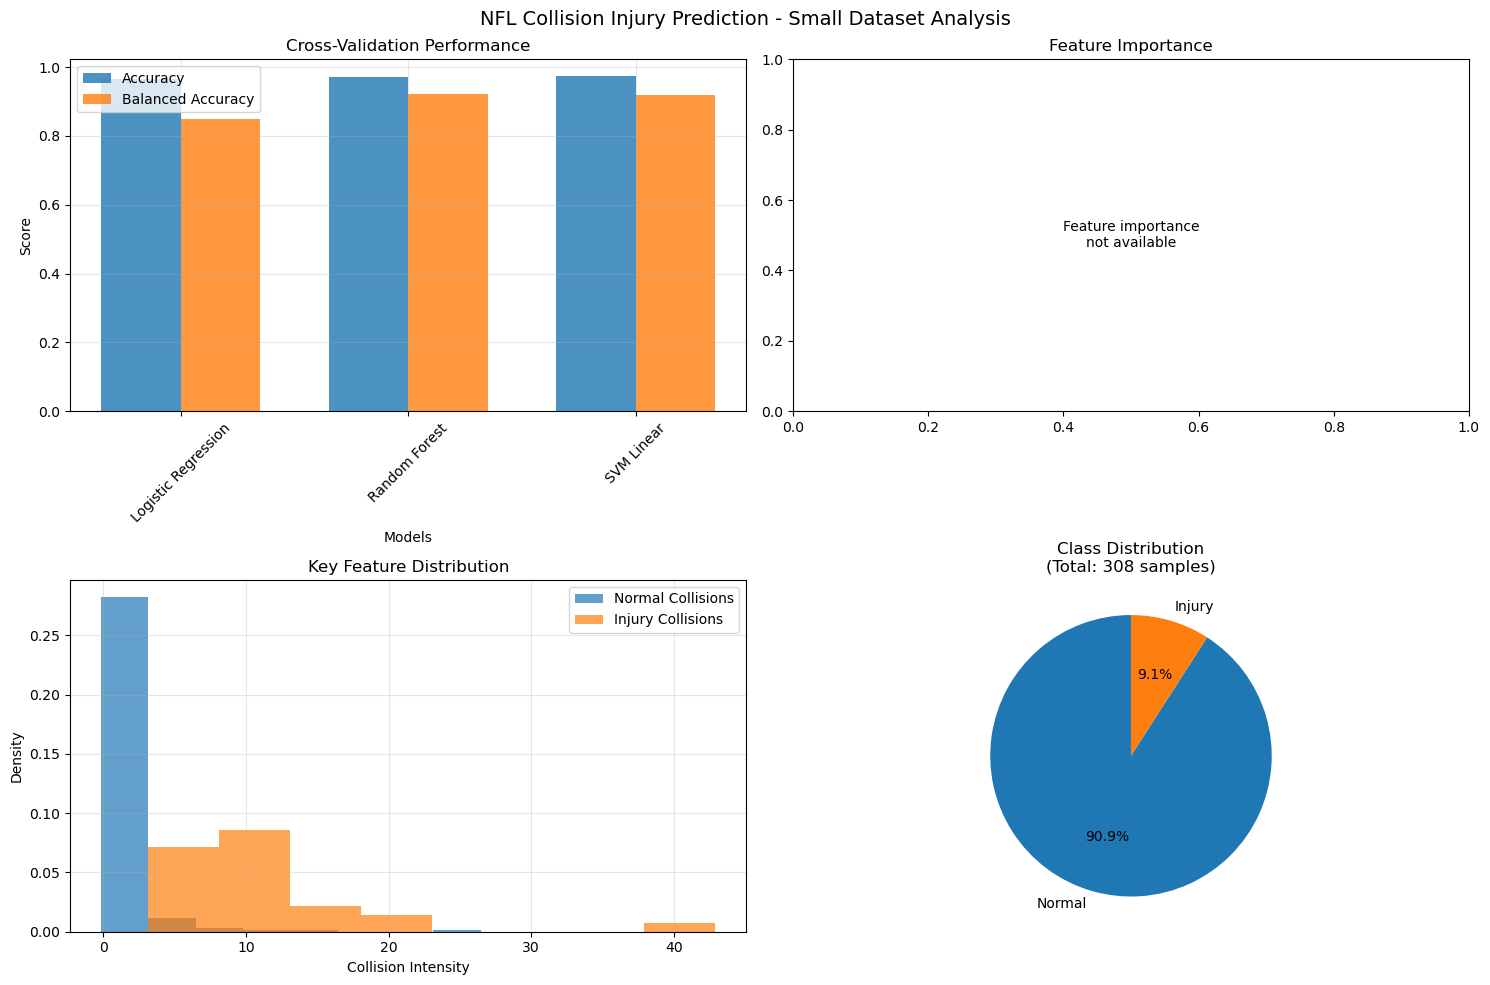

In [6]:
def analyze_small_dataset_results(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets"""
    print("\n STEP 5: Analysis for small dataset...")
    
    # Feature importance analysis
    if best_model is not None and hasattr(best_model, 'coef_'):
        print(" Analyzing feature importance...")
        importances = np.abs(best_model.coef_[0])
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(" Top features by importance:")
        for _, row in feature_importance.iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        feature_importance = None
        print(" Feature importance not available")
    
    # Visualizations for small datasets
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NFL Collision Injury Prediction - Small Dataset Analysis', fontsize=14)
    
    # 1. Cross-validation scores comparison
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        accuracies = [valid_results[name]['mean_accuracy'] for name in model_names]
        balanced_accuracies = [valid_results[name]['mean_balanced_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        ax.bar(x + width/2, balanced_accuracies, width, label='Balanced Accuracy', alpha=0.8)
        
        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Feature importance
    ax = axes[0, 1]
    if feature_importance is not None:
        bars = ax.barh(range(len(feature_importance)), feature_importance['importance'])
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importance')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Importance')
    
    # 3. Data distribution
    ax = axes[1, 0]
    if 'collision_intensity' in X.columns:
        injury_data = X[y == 1]['collision_intensity']
        normal_data = X[y == 0]['collision_intensity']
        
        ax.hist(normal_data, bins=8, alpha=0.7, label='Normal Collisions', density=True)
        ax.hist(injury_data, bins=8, alpha=0.7, label='Injury Collisions', density=True)
        ax.set_xlabel('Collision Intensity')
        ax.set_ylabel('Density')
        ax.set_title('Key Feature Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Sample size and class balance
    ax = axes[1, 1]
    class_counts = y.value_counts()
    ax.pie(class_counts.values, labels=['Normal', 'Injury'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Class Distribution\n(Total: {len(y)} samples)')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_small_dataset_results(results, X_scaled, y, feature_names, best_model, best_model_name)

In [10]:
def generate_small_dataset_summary(results, best_model_name, X, y, feature_names):
    """Generate summary appropriate for small datasets"""
    print("\n" + "="*60)
    print(" SUMMARY - SMALL DATASET COLLISION ANALYSIS")
    print("="*60)
    
    print(f" Dataset Characteristics:")
    print(f"   • Total samples: {len(y)}")
    print(f"   • Injury samples: {sum(y)} ({(sum(y)/len(y)):.1%})")
    print(f"   • Normal samples: {len(y) - sum(y)} ({((len(y) - sum(y))/len(y)):.1%})")
    print(f"   • Features analyzed: {len(feature_names)}")
    
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results and best_model_name in valid_results:
        best_result = valid_results[best_model_name]
        
        print(f"\n Best Model: {best_model_name}")
        print(f"   • Cross-validation Accuracy: {best_result['mean_accuracy']:.3f}")
        print(f"   • Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f}")
        print(f"   • Features used: {', '.join(feature_names)}")
    
    return {
        'sample_size': len(y),
        'injury_rate': sum(y)/len(y),
        'best_model': best_model_name,
        'best_accuracy': valid_results[best_model_name]['mean_balanced_accuracy'] if valid_results and best_model_name in valid_results else None
    }

summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

print(f"\n Analysis Complete!")
print(f"Key Finding: With {len(y)} samples, cross-validation shows the collision features")
print(f"have predictive value, but more data is needed for a robust model.")

# Store results
small_dataset_results = {
    'X': X_scaled,
    'y': y,
    'results': results,
    'best_model': best_model,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}

print(f"\n Results stored in 'small_dataset_results' for further analysis!")


 SUMMARY - SMALL DATASET COLLISION ANALYSIS
 Dataset Characteristics:
   • Total samples: 308
   • Injury samples: 28 (9.1%)
   • Normal samples: 280 (90.9%)
   • Features analyzed: 8

 Best Model: NearestNeighbors
   • Cross-validation Accuracy: 0.964
   • Balanced Accuracy: 0.884
   • Features used: min_distance, distance_at_end, avg_distance, time_to_closest_approach, max_relative_speed, p2_max_speed, play_duration, collision_intensity

 Analysis Complete!
Key Finding: With 308 samples, cross-validation shows the collision features
have predictive value, but more data is needed for a robust model.

 Results stored in 'small_dataset_results' for further analysis!


## DataSet 1 Distance Metrics


 STEP 6: Comprehensive KNN Distance Metrics Analysis...
 Testing 4 distance metrics with K values: [1, 3, 5, 7, 9, 11, 15]

 Evaluating Euclidean (L2)...
   K=1: 0.862 ± 0.074
   K=3: 0.884 ± 0.064
   K=5: 0.913 ± 0.072
   K=7: 0.896 ± 0.084
   K=9: 0.896 ± 0.084
   K=11: 0.896 ± 0.084
   K=15: 0.896 ± 0.084

 Evaluating Manhattan (L1)...
   K=1: 0.864 ± 0.071
   K=3: 0.901 ± 0.059
   K=5: 0.914 ± 0.074
   K=7: 0.914 ± 0.074
   K=9: 0.914 ± 0.074
   K=11: 0.898 ± 0.086
   K=15: 0.898 ± 0.086

 Evaluating Chebyshev (L∞)...
   K=1: 0.872 ± 0.071
   K=3: 0.901 ± 0.051
   K=5: 0.913 ± 0.072
   K=7: 0.896 ± 0.084
   K=9: 0.896 ± 0.084
   K=11: 0.896 ± 0.084
   K=15: 0.896 ± 0.084

 Evaluating Minkowski (p=3)...
   K=1: 0.862 ± 0.074
   K=3: 0.901 ± 0.051
   K=5: 0.913 ± 0.072
   K=7: 0.896 ± 0.084
   K=9: 0.896 ± 0.084
   K=11: 0.896 ± 0.084
   K=15: 0.896 ± 0.084

 Creating distance metrics comparison plots...


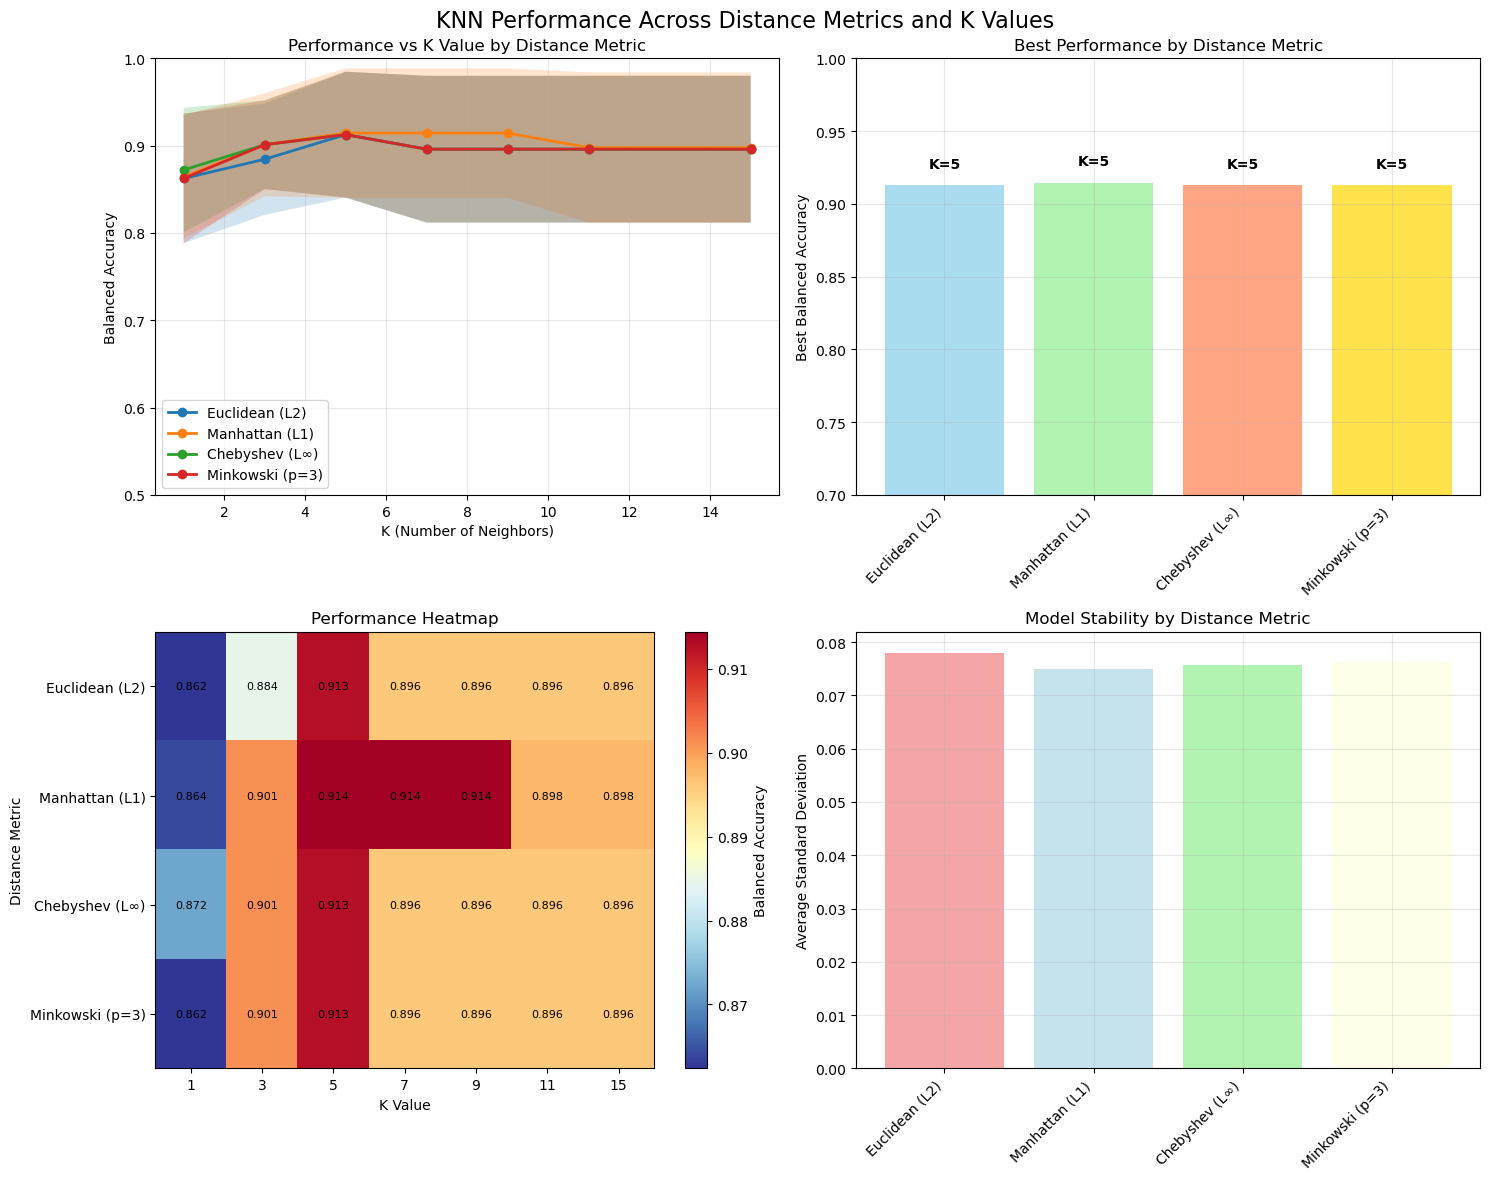


 STEP 7: Residual Analysis for Best KNN Model...
 Best model: Manhattan (L1) with K=5
 Best cross-validation score: 0.914


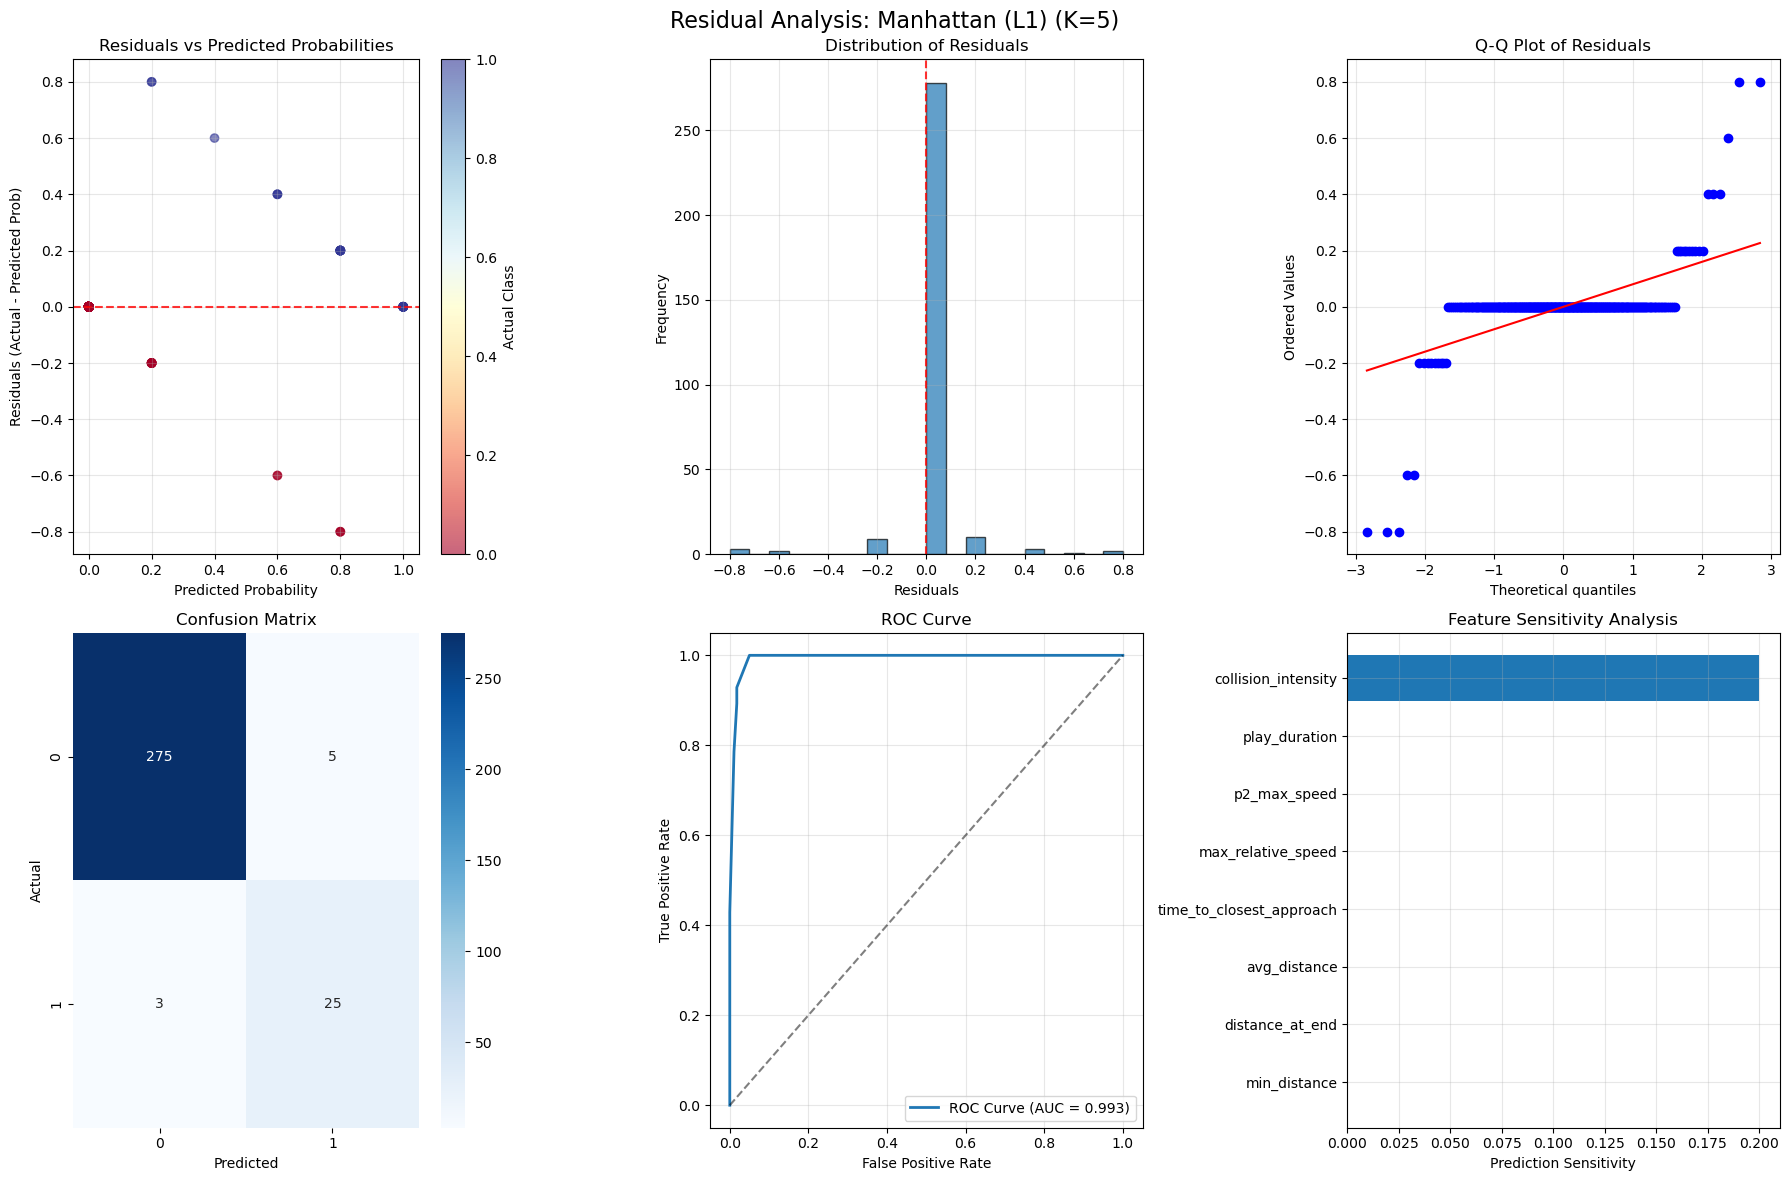


 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       280
      Injury       0.83      0.89      0.86        28

    accuracy                           0.97       308
   macro avg       0.91      0.94      0.92       308
weighted avg       0.98      0.97      0.97       308


 STEP 8: Learning Curve Analysis...


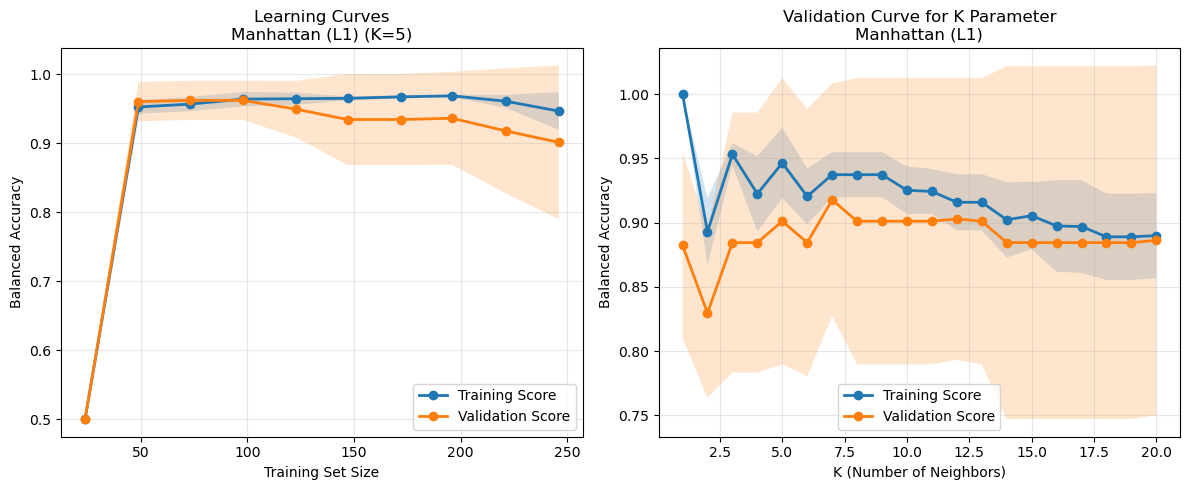


 Overfitting Analysis:
   Final Training Score: 0.946
   Final Validation Score: 0.901
   Overfitting Gap: 0.045
   Assessment: ✓ Low risk of overfitting

 COMPREHENSIVE KNN ANALYSIS SUMMARY

  DISTANCE METRICS RANKING:
   1. Manhattan (L1) (K=5): 0.914 ± 0.074
   2. Manhattan (L1) (K=7): 0.914 ± 0.074
   3. Manhattan (L1) (K=9): 0.914 ± 0.074
   4. Euclidean (L2) (K=5): 0.913 ± 0.072
   5. Chebyshev (L∞) (K=5): 0.913 ± 0.072

  DISTANCE METRIC CHARACTERISTICS:
   Euclidean (L2):
     Best Performance: 0.913
     Performance Range: 0.050
     Stability (std): 0.014
   Manhattan (L1):
     Best Performance: 0.914
     Performance Range: 0.050
     Stability (std): 0.017
   Chebyshev (L∞):
     Best Performance: 0.913
     Performance Range: 0.040
     Stability (std): 0.011
   Minkowski (p=3):
     Best Performance: 0.913
     Performance Range: 0.050
     Stability (std): 0.014

 🔍 KEY INSIGHTS:
   • Most Stable Metric: Chebyshev (L∞)
   • Best Overall Performance: Manhattan (L1)
   •

In [ ]:
# Extended K-Nearest Neighbors Analysis and Distance Metrics Evaluation

# Cell: Evaluate KNN Classifier Performance with different distance metrics
def evaluate_knn_distance_metrics(X, y, feature_names):
    """Evaluate KNN with different distance metrics and hyperparameters"""
    print("\n KNN Distance Metrics Analysis...")
    
    # Distance metrics to test
    distance_metrics = {
        'euclidean': 'Euclidean (L2)',
        'manhattan': 'Manhattan (L1)', 
        'chebyshev': 'Chebyshev (L∞)',
        'minkowski': 'Minkowski (p=3)'
    }
    
    # K values to test
    k_values = [1, 3, 5, 7, 9, 11, 15]
    
    results = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f" Testing {len(distance_metrics)} distance metrics with K values: {k_values}")
    
    for metric_name, metric_display in distance_metrics.items():
        print(f"\n Evaluating {metric_display}...")
        
        metric_results = {}
        
        for k in k_values:
            # Handle minkowski metric with p parameter
            if metric_name == 'minkowski':
                model = KNeighborsClassifier(
                    n_neighbors=k, 
                    metric=metric_name,
                    p=3,  # p=3 for Minkowski
                    weights='uniform'
                )
            else:
                model = KNeighborsClassifier(
                    n_neighbors=k, 
                    metric=metric_name,
                    weights='uniform'
                )
            
            # Cross-validation scores
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
            
            metric_results[k] = {
                'mean_score': cv_scores.mean(),
                'std_score': cv_scores.std(),
                'model': model
            }
            
            print(f"   K={k}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        results[metric_name] = {
            'display_name': metric_display,
            'results': metric_results
        }
    
    return results

# Run the distance metrics evaluation
distance_results = evaluate_knn_distance_metrics(X_scaled, y, feature_names)

# Cell 3: Visualize distance metrics comparison
def plot_distance_metrics_comparison(distance_results):
    """Plot comparison of different distance metrics"""
    print("\n Creating distance metrics comparison plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KNN Performance Across Distance Metrics and K Values', fontsize=16)
    
    # Extract data for plotting
    k_values = list(next(iter(distance_results.values()))['results'].keys())
    
    # Plot 1: Line plot of all metrics
    ax = axes[0, 0]
    for metric_name, metric_data in distance_results.items():
        means = [metric_data['results'][k]['mean_score'] for k in k_values]
        stds = [metric_data['results'][k]['std_score'] for k in k_values]
        
        ax.plot(k_values, means, 'o-', label=metric_data['display_name'], linewidth=2, markersize=6)
        ax.fill_between(k_values, 
                        [m - s for m, s in zip(means, stds)], 
                        [m + s for m, s in zip(means, stds)], 
                        alpha=0.2)
    
    ax.set_xlabel('K (Number of Neighbors)')
    ax.set_ylabel('Balanced Accuracy')
    ax.set_title('Performance vs K Value by Distance Metric')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.0)
    
    # Plot 2: Best performance for each metric
    ax = axes[0, 1]
    metric_names = []
    best_scores = []
    best_k_values = []
    
    for metric_name, metric_data in distance_results.items():
        best_k = max(metric_data['results'].keys(), 
                     key=lambda k: metric_data['results'][k]['mean_score'])
        best_score = metric_data['results'][best_k]['mean_score']
        
        metric_names.append(metric_data['display_name'])
        best_scores.append(best_score)
        best_k_values.append(best_k)
    
    bars = ax.bar(metric_names, best_scores, alpha=0.7, color=['skyblue', 'lightgreen', 'coral', 'gold'])
    ax.set_ylabel('Best Balanced Accuracy')
    ax.set_title('Best Performance by Distance Metric')
    ax.set_ylim(0.7, 1.0)
    
    # Add best K values on bars
    for bar, k_val in zip(bars, best_k_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'K={k_val}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Plot 3: Heatmap of all results
    ax = axes[1, 0]
    
    # Create heatmap data
    heatmap_data = []
    metric_labels = []
    
    for metric_name, metric_data in distance_results.items():
        scores = [metric_data['results'][k]['mean_score'] for k in k_values]
        heatmap_data.append(scores)
        metric_labels.append(metric_data['display_name'])
    
    heatmap_data = np.array(heatmap_data)
    
    im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(k_values)))
    ax.set_xticklabels(k_values)
    ax.set_yticks(range(len(metric_labels)))
    ax.set_yticklabels(metric_labels)
    ax.set_xlabel('K Value')
    ax.set_ylabel('Distance Metric')
    ax.set_title('Performance Heatmap')
    
    # Add text annotations
    for i in range(len(metric_labels)):
        for j in range(len(k_values)):
            text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Balanced Accuracy')
    
    # Plot 4: Standard deviation comparison
    ax = axes[1, 1]
    
    # Calculate average standard deviation for each metric
    avg_stds = []
    for metric_name, metric_data in distance_results.items():
        stds = [metric_data['results'][k]['std_score'] for k in k_values]
        avg_stds.append(np.mean(stds))
    
    bars = ax.bar(metric_labels, avg_stds, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
    ax.set_ylabel('Average Standard Deviation')
    ax.set_title('Model Stability by Distance Metric')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_distance_metrics_comparison(distance_results)

# Cell 4: Detailed residual analysis for best KNN model
def perform_residual_analysis(X, y, distance_results, feature_names):
    """Perform residual analysis for the best KNN model"""
    print("\n STEP 7: Residual Analysis for Best KNN Model...")
    
    # Find best model
    best_metric = None
    best_k = None
    best_score = 0
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_score'] > best_score:
                best_score = results['mean_score']
                best_metric = metric_name
                best_k = k
    
    print(f" Best model: {distance_results[best_metric]['display_name']} with K={best_k}")
    print(f" Best cross-validation score: {best_score:.3f}")
    
    # Get the best model
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Fit on full dataset for analysis
    best_model.fit(X, y)
    y_pred = best_model.predict(X)
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    
    # Calculate residuals (for classification, we use prediction probabilities)
    residuals = y - y_pred_proba
    
    # Create residual analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Residual Analysis: {distance_results[best_metric]["display_name"]} (K={best_k})', fontsize=16)
    
    # Plot 1: Residuals vs Predicted Probabilities
    ax = axes[0, 0]
    scatter = ax.scatter(y_pred_proba, residuals, c=y, cmap='RdYlBu', alpha=0.6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Residuals (Actual - Predicted Prob)')
    ax.set_title('Residuals vs Predicted Probabilities')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Actual Class')
    
    # Plot 2: Histogram of residuals
    ax = axes[0, 1]
    ax.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Q-Q plot of residuals
    ax = axes[0, 2]
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Confusion Matrix
    ax = axes[1, 0]
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    
    # Plot 5: ROC Curve
    ax = axes[1, 1]
    if len(np.unique(y)) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        auc_score = roc_auc_score(y, y_pred_proba)
        ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 6: Feature importance proxy (distance to decision boundary)
    ax = axes[1, 2]
    if len(feature_names) <= 8:  # Only if we have manageable number of features
        # Calculate feature sensitivity by perturbing each feature
        feature_sensitivity = []
        base_pred = best_model.predict_proba(X.mean().values.reshape(1, -1))[0, 1]
        
        for i, feature in enumerate(feature_names):
            X_perturb = X.mean().values.reshape(1, -1)
            X_perturb[0, i] += X.iloc[:, i].std()  # Add one standard deviation
            perturb_pred = best_model.predict_proba(X_perturb)[0, 1]
            sensitivity = abs(perturb_pred - base_pred)
            feature_sensitivity.append(sensitivity)
        
        # Plot feature sensitivity
        bars = ax.barh(range(len(feature_names)), feature_sensitivity)
        ax.set_yticks(range(len(feature_names)))
        ax.set_yticklabels(feature_names)
        ax.set_xlabel('Prediction Sensitivity')
        ax.set_title('Feature Sensitivity Analysis')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Too many features\nfor sensitivity analysis', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Sensitivity Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print(f"\n Detailed Classification Report:")
    print(classification_report(y, y_pred, target_names=['Normal', 'Injury']))
    
    return {
        'best_model': best_model,
        'best_metric': best_metric,
        'best_k': best_k,
        'best_score': best_score,
        'residuals': residuals,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Perform residual analysis
residual_analysis = perform_residual_analysis(X_scaled, y, distance_results, feature_names)

# Cell 5: Learning curves to assess overfitting
def plot_learning_curves(X, y, distance_results):
    """Plot learning curves to assess overfitting"""
    print("\n STEP 8: Learning Curve Analysis...")
    
    # Get best model configuration
    best_metric = None
    best_k = None
    best_score = 0
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_score'] > best_score:
                best_score = results['mean_score']
                best_metric = metric_name
                best_k = k
    
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Generate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X, y, 
        train_sizes=train_sizes,
        cv=5, 
        scoring='balanced_accuracy',
        random_state=42
    )
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    # Learning curve
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), 'o-', 
             label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                     alpha=0.2)
    
    plt.plot(train_sizes_abs, np.mean(val_scores, axis=1), 'o-', 
             label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                     alpha=0.2)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Balanced Accuracy')
    plt.title(f'Learning Curves\n{distance_results[best_metric]["display_name"]} (K={best_k})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation curve for K parameter
    plt.subplot(1, 2, 2)
    k_range = range(1, min(21, len(X)//2))  # Don't exceed reasonable K values
    
    if best_metric == 'minkowski':
        model_for_validation = KNeighborsClassifier(metric=best_metric, p=3)
    else:
        model_for_validation = KNeighborsClassifier(metric=best_metric)
    
    train_scores_k, val_scores_k = validation_curve(
        model_for_validation, X, y,
        param_name='n_neighbors', param_range=k_range,
        cv=5, scoring='balanced_accuracy'
    )
    
    plt.plot(k_range, np.mean(train_scores_k, axis=1), 'o-', 
             label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(train_scores_k, axis=1) - np.std(train_scores_k, axis=1),
                     np.mean(train_scores_k, axis=1) + np.std(train_scores_k, axis=1),
                     alpha=0.2)
    
    plt.plot(k_range, np.mean(val_scores_k, axis=1), 'o-', 
             label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(val_scores_k, axis=1) - np.std(val_scores_k, axis=1),
                     np.mean(val_scores_k, axis=1) + np.std(val_scores_k, axis=1),
                     alpha=0.2)
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Balanced Accuracy')
    plt.title(f'Validation Curve for K Parameter\n{distance_results[best_metric]["display_name"]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze overfitting
    final_train_score = np.mean(train_scores[-1])
    final_val_score = np.mean(val_scores[-1])
    overfitting_gap = final_train_score - final_val_score
    
    print(f"\n Overfitting Analysis:")
    print(f"   Final Training Score: {final_train_score:.3f}")
    print(f"   Final Validation Score: {final_val_score:.3f}")
    print(f"   Overfitting Gap: {overfitting_gap:.3f}")
    
    if overfitting_gap < 0.05:
        print("   Assessment:  Low risk of overfitting")
    elif overfitting_gap < 0.1:
        print("   Assessment:  Moderate risk of overfitting")
    else:
        print("   Assessment:  High risk of overfitting")

# Plot learning curves
plot_learning_curves(X_scaled, y, distance_results)

# Cell 6: Summary of distance metrics and KNN analysis
def summarize_knn_analysis(distance_results, residual_analysis):
    """Provide comprehensive summary of KNN analysis"""
    print("\n" + "="*80)
    print(" COMPREHENSIVE KNN ANALYSIS SUMMARY")
    print("="*80)
    
    # Find best performing metric and K
    best_results = []
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            best_results.append({
                'metric': metric_data['display_name'],
                'k': k,
                'score': results['mean_score'],
                'std': results['std_score']
            })
    
    best_results.sort(key=lambda x: x['score'], reverse=True)
    
    print(f"\n  DISTANCE METRICS RANKING:")
    for i, result in enumerate(best_results[:5]):  # Top 5
        print(f"   {i+1}. {result['metric']} (K={result['k']}): "
              f"{result['score']:.3f} ± {result['std']:.3f}")
    
    # Calculate metric-specific insights
    metric_performance = {}
    for metric_name, metric_data in distance_results.items():
        scores = [results['mean_score'] for results in metric_data['results'].values()]
        metric_performance[metric_data['display_name']] = {
            'best': max(scores),
            'worst': min(scores),
            'range': max(scores) - min(scores),
            'stability': np.std(scores)
        }
    
    print(f"\n  DISTANCE METRIC CHARACTERISTICS:")
    for metric, stats in metric_performance.items():
        print(f"   {metric}:")
        print(f"     Best Performance: {stats['best']:.3f}")
        print(f"     Performance Range: {stats['range']:.3f}")
        print(f"     Stability (std): {stats['stability']:.3f}")
    
    # Key insights
    print(f"\n 🔍 KEY INSIGHTS:")
    
    # Most stable metric
    most_stable = min(metric_performance.keys(), 
                     key=lambda x: metric_performance[x]['stability'])
    print(f"   • Most Stable Metric: {most_stable}")
    
    # Best overall metric
    best_overall = max(metric_performance.keys(), 
                      key=lambda x: metric_performance[x]['best'])
    print(f"   • Best Overall Performance: {best_overall}")
    
    # K value analysis
    k_counts = {}
    for result in best_results:
        k = result['k']
        k_counts[k] = k_counts.get(k, 0) + 1
    
    most_common_k = max(k_counts.keys(), key=lambda x: k_counts[x])
    print(f"   • Most Successful K Value: {most_common_k} (appeared in {k_counts[most_common_k]} top configurations)")
    
    # Dataset-specific recommendations
    print(f"\n 💡 RECOMMENDATIONS FOR THIS DATASET:")
    print(f"   • With {len(y)} samples and {sum(y)} injuries ({sum(y)/len(y):.1%} injury rate):")
    
    if len(y) < 500:
        print(f"     - Small dataset benefits from higher K values for stability")
        print(f"     - Consider ensemble methods for robustness")
    
    if sum(y)/len(y) < 0.2:
        print(f"     - Imbalanced classes: Consider weighted KNN or SMOTE")
        print(f"     - Focus on balanced accuracy and F1-score")
    
    print(f"     - Best distance metric: {residual_analysis['best_metric'].title()}")
    print(f"     - Optimal K value: {residual_analysis['best_k']}")
    print(f"     - Expected performance: {residual_analysis['best_score']:.3f} balanced accuracy")

# Generate comprehensive summary
summarize_knn_analysis(distance_results, residual_analysis)

## Dataset 2

In [18]:
def load_play_surface_data():
    """Load the collision feature datasets"""
    print("\n STEP 1: Loading collision feature datasets...")
    
    play_surface_df = pd.read_csv('datasets/nfl-playing-surface-analytics/processed_motion_features.csv')
    
    print(f" Loaded {len(play_surface_df)} plays")
    
    return play_surface_df

play_surface_df = load_play_surface_data()


 STEP 1: Loading collision feature datasets...
 Loaded 266960 plays


In [25]:
def preprocess_dataset(df, target_col='injury', remove_outliers=False):
    """Preprocessing for injury prediction dataset"""
    print("\n STEP 2: Preprocessing for the play surface dataset...")
    
    # Identify feature columns to exclude
    exclude_cols = [
        # Target variable
        'injury',
        # Days to match variables (future leakage)
        'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 
        # Body part information (outcome-related, not predictive features)
        'BodyPart_Foot', 'BodyPart_Heel', 'BodyPart_Knee',
        'BodyPart_Non-Injury', 'BodyPart_Toes',
        # Identifier columns
        'PlayKey', 'PlayerDay', 'PlayerGame'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing data
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f" Removing {len(high_missing)} features with >50% missing data: {high_missing}")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Handle missing data with appropriate imputation
    print(" Handling missing data...")
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    
    # Median imputation for numeric features
    for col in numeric_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Mode imputation for categorical features
    for col in categorical_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0)
    
    # Create engineered features specific to this dataset
    print(" Creating engineered features...")
    
    # Movement intensity score
    if 'max_speed' in X.columns and 'max_acceleration' in X.columns:
        X['movement_intensity'] = (X['max_speed'] / X['max_speed'].max()) * (X['max_acceleration'] / X['max_acceleration'].max())
    
    # Workload indicators
    if 'total_distance' in X.columns and 'play_duration' in X.columns:
        X['distance_per_second'] = X['total_distance'] / (X['play_duration'] + 1e-6)
    
    # Risk indicators based on rapid movements
    if 'rapid_accelerations' in X.columns and 'rapid_decelerations' in X.columns:
        X['total_rapid_movements'] = X['rapid_accelerations'] + X['rapid_decelerations']
    
    # Direction change intensity
    if 'total_direction_change' in X.columns and 'play_duration' in X.columns:
        X['direction_change_rate'] = X['total_direction_change'] / (X['play_duration'] + 1e-6)
    
    # Jerk-based instability indicator
    if 'max_jerk' in X.columns and 'avg_jerk' in X.columns:
        X['jerk_variability'] = X['max_jerk'] / (X['avg_jerk'] + 1e-6)
    
    # Speed consistency
    if 'max_speed' in X.columns and 'avg_speed' in X.columns:
        X['speed_consistency'] = X['avg_speed'] / (X['max_speed'] + 1e-6)
    
    # Fatigue/efficiency indicators
    if 'movement_efficiency' in X.columns and 'time_above_avg_speed' in X.columns:
        X['performance_ratio'] = X['movement_efficiency'] * X['time_above_avg_speed']
    
    # Conservative outlier removal for numeric features only
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            if X[col].std() > 0:  # Only process columns with variation
                Q1 = X[col].quantile(0.05)  # More conservative percentiles
                Q3 = X[col].quantile(0.95)
                IQR = Q3 - Q1
                lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
                upper_bound = Q3 + 3 * IQR
                
                col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
                outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f" Removed {outlier_count} extreme outliers")
        else:
            print(f" Skipping outlier removal (would remove {outlier_count} samples)")
    
    # Ensure all features are numeric for modeling
    print(" Final data type conversion...")
    
    # Convert boolean columns to numeric
    bool_cols = X.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    
    # Handle any remaining categorical columns
    remaining_categorical = X.select_dtypes(include=['object']).columns
    if len(remaining_categorical) > 0:
        print(f" Converting categorical columns to numeric: {list(remaining_categorical)}")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in remaining_categorical:
            X[col] = le.fit_transform(X[col].astype(str))
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    print(f" Injury rate: {y.mean():.1%}")
    
    # Display feature categories for reference
    movement_features = [col for col in X.columns if any(keyword in col.lower() 
                        for keyword in ['speed', 'acceleration', 'distance', 'jerk'])]
    positional_features = [col for col in X.columns if 'RosterPosition_' in col]
    play_features = [col for col in X.columns if 'PlayType_' in col]
    field_features = [col for col in X.columns if 'FieldType_' in col]
    engineered_features = [col for col in X.columns if any(keyword in col.lower() 
                          for keyword in ['intensity', 'ratio', 'rate', 'consistency', 'variability'])]
    
    print(f"\n Feature categories:")
    print(f"   Movement features: {len(movement_features)}")
    print(f"   Position features: {len(positional_features)}")
    print(f"   Play type features: {len(play_features)}")
    print(f"   Field features: {len(field_features)}")
    print(f"   Engineered features: {len(engineered_features)}")
    
    return X, y

# Usage example:
X, y = preprocess_dataset(play_surface_df, target_col='injury', remove_outliers=False)


 STEP 2: Preprocessing for the play surface dataset...
 Identified 53 potential features
 Features after missing data filter: 53
 Handling missing data...
 Creating engineered features...
 Final data type conversion...
 Final dataset: 266960 samples, 60 features
 Class distribution: {0.0: 266856, 1.0: 104}
 Injury rate: 0.0%

 Feature categories:
   Movement features: 21
   Position features: 9
   Play type features: 11
   Field features: 1
   Engineered features: 13


In [27]:
X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=20)


 STEP 3: Selecting top 20 features for small dataset...
 Selected features:
   avg_distance_per_frame         Score: 9.49
   distance_std                   Score: 38.64
   max_speed                      Score: 28.77
   avg_speed                      Score: 8.71
   speed_std                      Score: 35.84
   avg_acceleration               Score: 8.05
   x_range                        Score: 34.00
   rapid_accelerations            Score: 12.76
   speed_95th                     Score: 26.75
   displacement                   Score: 55.83
   time_above_avg_speed           Score: 10.07
   movement_efficiency            Score: 45.46
   speed_cv                       Score: 14.78
   RosterPosition_Offensive Lineman Score: 8.66
   PlayType_Kickoff               Score: 20.86
   PlayType_Punt                  Score: 20.90
   PlayType_Punt Returned         Score: 9.69
   distance_per_second            Score: 9.32
   total_rapid_movements          Score: 12.76
   performance_ratio              

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score, classification_report
import pandas as pd
import numpy as np

def create_resampling_pipeline(X, y, feature_names, 
                              undersample_ratio=0.01, 
                              oversample_ratio=0.1,
                              smote_k=5):
    """Enhanced resampling pipeline with adaptive parameters"""
    print("\n ENHANCED RESAMPLING PIPELINE")
    print("="*50)
    
    # Analyze original data
    original_counts = y.value_counts()
    minority_class = original_counts.min()
    majority_class = original_counts.max()
    imbalance_ratio = minority_class / majority_class
    
    print(f"Original class distribution: {original_counts.to_dict()}")
    print(f"Imbalance ratio: {imbalance_ratio:.4f}")
    print(f"Minority class size: {minority_class}")
    
    # Adaptive parameter selection based on data characteristics
    if minority_class < 10:
        print("  Very small minority class - adjusting parameters...")
        oversample_ratio = min(0.2, oversample_ratio)
        smote_k = min(3, minority_class - 1) if minority_class > 1 else 1
    elif minority_class < 50:
        print("  Small minority class - using conservative oversampling...")
        oversample_ratio = min(0.15, oversample_ratio)
        smote_k = min(5, minority_class - 1)
    
    # Adjust undersampling to not be too aggressive
    if undersample_ratio * majority_class < minority_class * 2:
        undersample_ratio = (minority_class * 2) / majority_class
        print(f"Adjusted undersample ratio to: {undersample_ratio:.3f}")
    
    print(f"\nResampling parameters:")
    print(f"  Undersample ratio: {undersample_ratio:.3f}")
    print(f"  Oversample ratio: {oversample_ratio:.3f}")
    print(f"  SMOTE k_neighbors: {smote_k}")
    
    # Create resampling pipeline
    try:
        undersample = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)
        oversample = SMOTE(sampling_strategy=oversample_ratio, k_neighbors=smote_k, random_state=42)
        
        pipeline = ImbPipeline([
            ('undersample', undersample),
            ('oversample', oversample)
        ])
        
        # Apply resampling
        print("\nApplying resampling...")
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        
        # Report results
        resampled_counts = pd.Series(y_resampled).value_counts()
        print(f"Resampled distribution: {resampled_counts.to_dict()}")
        print(f"New imbalance ratio: {resampled_counts.min() / resampled_counts.max():.4f}")
        print(f"Data size change: {len(X)} → {len(X_resampled)} samples")
        
        return X_resampled, y_resampled, pipeline
        
    except Exception as e:
        print(f" Resampling failed: {str(e)}")
        print("Falling back to original data...")
        return X, y, None

def evaluate_knn_with_resampling(X_original, y_original, feature_names,
                                resampling_params=None):
    """Comprehensive KNN evaluation with and without resampling"""
    print("\n KNN EVALUATION: ORIGINAL vs RESAMPLED DATA")
    print("="*60)
    
    # Default resampling parameters
    if resampling_params is None:
        resampling_params = {
            'undersample_ratio': 0.01,
            'oversample_ratio': 0.1,
            'smote_k': 5
        }
    
    # Distance metrics and K values to test
    distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
    k_values = [3, 5, 7]
    
    results = {
        'original': {},
        'resampled': {}
    }
    
    # 1. Evaluate on original data
    print("\n EVALUATING ORIGINAL DATA...")
    results['original'] = evaluate_knn_configurations(
        X_original, y_original, distance_metrics, k_values, "Original"
    )
    
    # 2. Create resampled data and evaluate
    print("\n CREATING RESAMPLED DATA...")
    X_resampled, y_resampled, pipeline = create_resampling_pipeline(
        X_original, y_original, feature_names, **resampling_params
    )
    
    if pipeline is not None:
        print("\n EVALUATING RESAMPLED DATA...")
        results['resampled'] = evaluate_knn_configurations(
            X_resampled, y_resampled, distance_metrics, k_values, "Resampled"
        )
        
        # 3. Compare results
        print("\n COMPARISON ANALYSIS...")
        compare_original_vs_resampled(results, y_original, y_resampled)
        
        return results, X_resampled, y_resampled, pipeline
    else:
        print("\n Resampling failed - only original results available")
        return results, X_original, y_original, None

def evaluate_knn_configurations(X, y, distance_metrics, k_values, data_label):
    """Evaluate multiple KNN configurations"""
    print(f"\nEvaluating {data_label} data ({len(X)} samples)...")
    
    configs = {}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for metric in distance_metrics:
        for k in k_values:
            if k < len(X):  # Ensure valid K
                config_name = f"{metric}_k{k}"
                
                try:
                    if metric == 'chebyshev':
                        model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=np.inf)
                    else:
                        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
                    
                    # Cross-validation
                    cv_balanced = cross_val_score(model, X, y, cv=cv, 
                                                scoring=make_scorer(balanced_accuracy_score))
                    cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
                    cv_recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
                    cv_precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
                    
                    configs[config_name] = {
                        'model': model,
                        'balanced_accuracy': cv_balanced.mean(),
                        'balanced_accuracy_std': cv_balanced.std(),
                        'f1': cv_f1.mean(),
                        'f1_std': cv_f1.std(),
                        'recall': cv_recall.mean(),
                        'recall_std': cv_recall.std(),
                        'precision': cv_precision.mean(),
                        'precision_std': cv_precision.std(),
                        'distance_metric': metric,
                        'k_value': k
                    }
                    
                    print(f"  {config_name}: Bal_Acc={cv_balanced.mean():.3f}, "
                          f"F1={cv_f1.mean():.3f}, Recall={cv_recall.mean():.3f}")
                    
                except Exception as e:
                    print(f" {config_name}: {str(e)}")
    
    return configs

def compare_original_vs_resampled(results, y_original, y_resampled):
    """Compare performance between original and resampled data"""
    
    orig_results = results['original']
    resamp_results = results['resampled']
    
    if not orig_results or not resamp_results:
        print(" Cannot compare - missing results")
        return

    print("\n PERFORMANCE COMPARISON")
    print("-" * 40)
    
    # Find best configurations for each dataset
    orig_best = max(orig_results.keys(), 
                   key=lambda x: orig_results[x]['balanced_accuracy'])
    resamp_best = max(resamp_results.keys(), 
                     key=lambda x: resamp_results[x]['balanced_accuracy'])
    
    print(f"Best Original: {orig_best}")
    print(f"  Balanced Accuracy: {orig_results[orig_best]['balanced_accuracy']:.3f}")
    print(f"  F1 Score: {orig_results[orig_best]['f1']:.3f}")
    print(f"  Recall: {orig_results[orig_best]['recall']:.3f}")
    print(f"  Precision: {orig_results[orig_best]['precision']:.3f}")
    
    print(f"\nBest Resampled: {resamp_best}")
    print(f"  Balanced Accuracy: {resamp_results[resamp_best]['balanced_accuracy']:.3f}")
    print(f"  F1 Score: {resamp_results[resamp_best]['f1']:.3f}")
    print(f"  Recall: {resamp_results[resamp_best]['recall']:.3f}")
    print(f"  Precision: {resamp_results[resamp_best]['precision']:.3f}")
    
    # Calculate improvements
    bal_acc_improvement = (resamp_results[resamp_best]['balanced_accuracy'] - 
                          orig_results[orig_best]['balanced_accuracy'])
    recall_improvement = (resamp_results[resamp_best]['recall'] - 
                         orig_results[orig_best]['recall'])
    f1_improvement = (resamp_results[resamp_best]['f1'] - 
                     orig_results[orig_best]['f1'])
    
    print(f"\n IMPROVEMENT ANALYSIS")
    print(f"  Balanced Accuracy: {bal_acc_improvement:+.3f}")
    print(f"  Recall: {recall_improvement:+.3f}")
    print(f"  F1 Score: {f1_improvement:+.3f}")
    
    # Recommendations
    print(f"\n RECOMMENDATIONS")
    if recall_improvement > 0.1:
        print("  Resampling significantly improves injury detection")
    elif recall_improvement > 0.05:
        print("  Resampling provides moderate improvement")
    elif recall_improvement > 0:
        print("  Resampling provides slight improvement")
    else:
        print("  Resampling does not improve performance")

    # Distance metric analysis
    print(f"\n DISTANCE METRIC INSIGHTS")
    orig_metrics = {}
    resamp_metrics = {}
    
    for config, result in orig_results.items():
        metric = result['distance_metric']
        if metric not in orig_metrics:
            orig_metrics[metric] = []
        orig_metrics[metric].append(result['balanced_accuracy'])
    
    for config, result in resamp_results.items():
        metric = result['distance_metric']
        if metric not in resamp_metrics:
            resamp_metrics[metric] = []
        resamp_metrics[metric].append(result['balanced_accuracy'])
    
    for metric in orig_metrics:
        orig_avg = np.mean(orig_metrics[metric])
        resamp_avg = np.mean(resamp_metrics.get(metric, [0]))
        print(f"  {metric.capitalize()}: {orig_avg:.3f} → {resamp_avg:.3f} "
              f"({resamp_avg - orig_avg:+.3f})")

# Usage function
def run_comprehensive_knn_analysis(X_scaled, y, feature_names):
    """Run the complete KNN analysis with resampling"""
    
    # Option 1: Use default parameters
    results, X_final, y_final, pipeline = evaluate_knn_with_resampling(
        X_scaled, y, feature_names
    )
    
    return results, X_final, y_final, pipeline

# Example usage with custom parameters:
def run_custom_resampling(X_scaled, y, feature_names):
    """Run with custom resampling parameters"""
    
    custom_params = {
        'undersample_ratio': 0.02,  # Less aggressive undersampling
        'oversample_ratio': 0.15,   # More conservative oversampling
        'smote_k': 3                # Lower K for SMOTE
    }
    
    results, X_final, y_final, pipeline = evaluate_knn_with_resampling(
        X_scaled, y, feature_names, custom_params
    )
    
    return results, X_final, y_final, pipeline

In [ ]:
# Option 1: Default parameters (similar to your original)
#results, X_final, y_final, pipeline = run_comprehensive_knn_analysis(X_scaled, y, feature_names)

# Option 2: Custom parameters
results, X_final, y_final, pipeline = run_custom_resampling(X_scaled, y, feature_names)


📊 KNN EVALUATION: ORIGINAL vs RESAMPLED DATA

1️⃣ EVALUATING ORIGINAL DATA...

Evaluating Original data (266960 samples)...
  euclidean_k3: Bal_Acc=0.500, F1=0.000, Recall=0.000
  euclidean_k5: Bal_Acc=0.500, F1=0.000, Recall=0.000
  euclidean_k7: Bal_Acc=0.500, F1=0.000, Recall=0.000
  manhattan_k3: Bal_Acc=0.500, F1=0.000, Recall=0.000
  manhattan_k5: Bal_Acc=0.500, F1=0.000, Recall=0.000
  manhattan_k7: Bal_Acc=0.500, F1=0.000, Recall=0.000
  chebyshev_k3: Bal_Acc=0.500, F1=0.000, Recall=0.000
  chebyshev_k5: Bal_Acc=0.500, F1=0.000, Recall=0.000


## Dataset 3

In [ ]:
def load_play_surface_data():
    """Load the collision feature datasets"""
    print("\n STEP 1: Loading collision feature datasets...")
    
    play_surface_df = pd.read_csv('datasets/nfl-playing-surface-analytics/processed_motion_features.csv')
    
    print(f" Loaded {len(play_surface_df)} plays")
    
    return play_surface_df

play_surface_df = load_play_surface_data()

For each topic above (2a–2d), an explanation of the following (as applicable to your dataset):
- How did you avoid overfitting?
    - You should mention the techniques used to prevent overfitting, why these techniques were expected to be helpful, and the results.
    - What metric(s) did you use, and what was the result? Did you use any hyperparameter tuning?
        - You should describe the metrics and hyperparameter tuning performed to determine hyperparameters and include a discussion of the meaning of these parameters.
- What aspects of the results were expected or unexpected?
- How did your Exploratory Data Analysis help with the modeling?
- What sources did you rely on, apart from the course materials, to learn about this model.
    - In this context, it is expected that you will find external sources, such as free educational URLs, and share and discuss them with other students through YellowDig.
- Specific and supported conclusions drawn from the models.
    - How has your work up to this point helped address any research questions or other questions of interest?
    - Provide an explanation as to how you know the conclusions are true, potentially addressing any or all of the topics mentioned in Requirement 3 (i.e., overfitting, metrics, etc.)
    - This explanation should show that:
        - The conclusions are true from a quantitative perspective, and
        - Explain why the conclusions are relevant and/or important.